In [1]:
!pip install scikit-learn pandas matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)


In [3]:
from google.colab import files

print("Upload trainingData.csv from the UJIIndoorLoc dataset.")
uploaded = files.upload()

df = pd.read_csv('trainingData.csv')
df.head()


Upload trainingData.csv from the UJIIndoorLoc dataset.


Saving trainingData.csv to trainingData.csv


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [4]:
import pandas as pd

df = pd.read_csv("trainingData.csv")

df.shape


(19937, 529)

In [5]:
wifi_cols = df.columns[:520]
label_cols = ['BUILDINGID', 'FLOOR']

df[wifi_cols].head(), df[label_cols].head()


(   WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
 0     100     100     100     100     100     100     100     100     100   
 1     100     100     100     100     100     100     100     100     100   
 2     100     100     100     100     100     100     100     -97     100   
 3     100     100     100     100     100     100     100     100     100   
 4     100     100     100     100     100     100     100     100     100   
 
    WAP010  ...  WAP511  WAP512  WAP513  WAP514  WAP515  WAP516  WAP517  \
 0     100  ...     100     100     100     100     100     100     100   
 1     100  ...     100     100     100     100     100     100     100   
 2     100  ...     100     100     100     100     100     100     100   
 3     100  ...     100     100     100     100     100     100     100   
 4     100  ...     100     100     100     100     100     100     100   
 
    WAP518  WAP519  WAP520  
 0     100     100     100  
 1     100     100  

In [6]:
# Replace '100' (no signal) with a realistic RSSI noise floor
df[wifi_cols] = df[wifi_cols].replace(100, -110)

df[wifi_cols].head()     # Check that it worked


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110
1,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110
2,-110,-110,-110,-110,-110,-110,-110,-97,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110
3,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110
4,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110,...,-110,-110,-110,-110,-110,-110,-110,-110,-110,-110


In [7]:
df.info()
df[wifi_cols].describe().T.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 80.5 MB


,count,mean,std,min,25%,50%,75%,max
WAP001,19937.0,-109.986758,0.441757,-110.0,-110.0,-110.0,-110.0,-93.0
WAP002,19937.0,-109.978934,0.684879,-110.0,-110.0,-110.0,-110.0,-86.0
WAP003,19937.0,-110.000000,0.000000,-110.0,-110.0,-110.0,-110.0,-110.0
WAP004,19937.0,-110.000000,0.000000,-110.0,-110.0,-110.0,-110.0,-110.0
WAP005,19937.0,-109.964940,0.787725,-110.0,-110.0,-110.0,-110.0,-89.0


In [8]:
df['BUILDING_FLOOR'] = df['BUILDINGID'].astype(str) + "_" + df['FLOOR'].astype(str)
df['BUILDING_FLOOR'].value_counts()


/tmp/ipython-input-1621230626.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BUILDING_FLOOR'] = df['BUILDINGID'].astype(str) + "_" + df['FLOOR'].astype(str)


,count
BUILDING_FLOOR,
2_3,2709
2_1,2162
2_0,1942
2_2,1577
1_1,1484
0_2,1443
1_2,1396
0_3,1391
1_0,1368


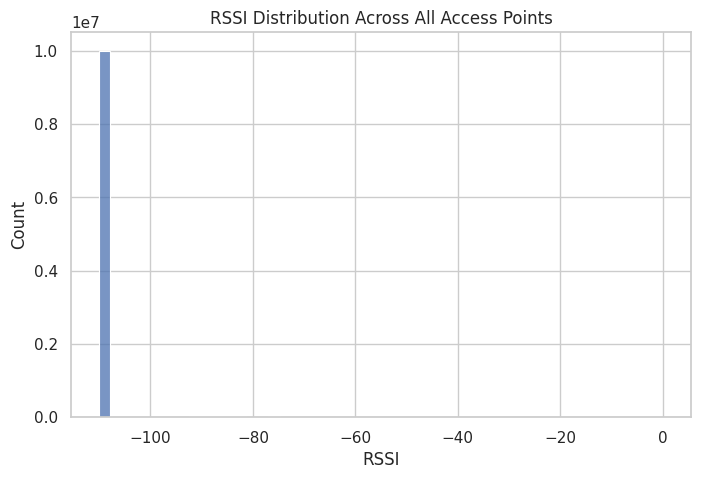

In [9]:
all_rssi = df[wifi_cols].values.flatten()

sns.histplot(all_rssi, bins=50)
plt.title("RSSI Distribution Across All Access Points")
plt.xlabel("RSSI")
plt.ylabel("Count")
plt.show()


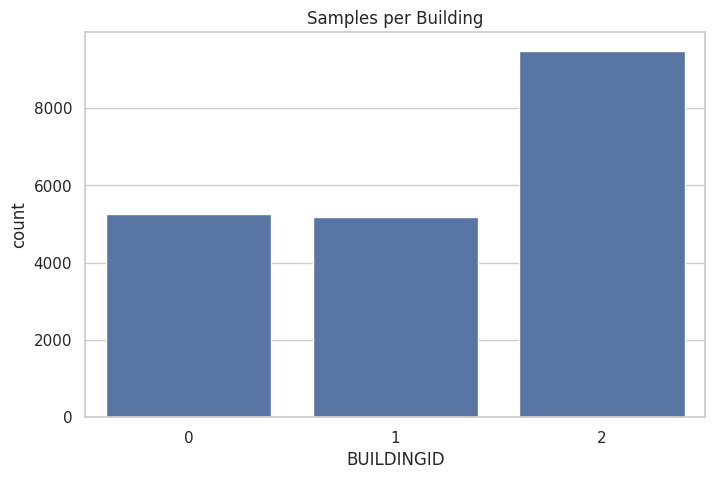

In [10]:
sns.countplot(x=df['BUILDINGID'])
plt.title("Samples per Building")
plt.show()


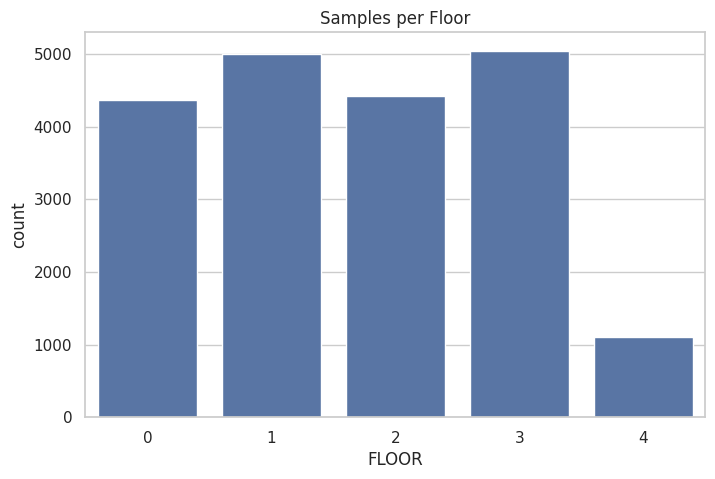

In [11]:
sns.countplot(x=df['FLOOR'])
plt.title("Samples per Floor")
plt.show()


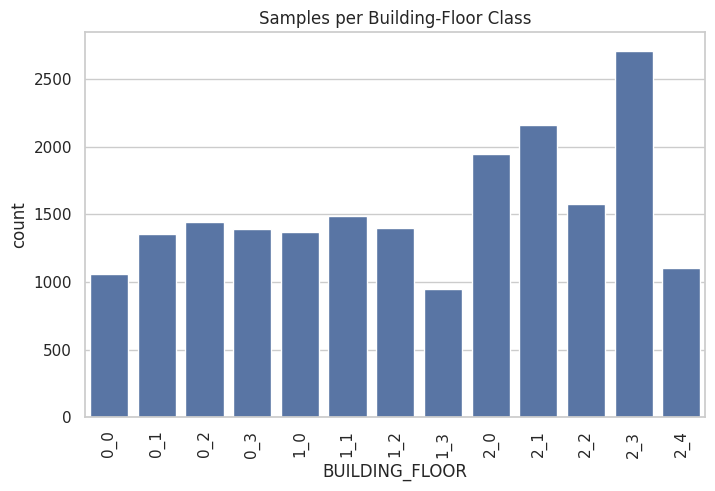

In [12]:
sns.countplot(x=df['BUILDING_FLOOR'], order=sorted(df['BUILDING_FLOOR'].unique()))
plt.title("Samples per Building-Floor Class")
plt.xticks(rotation=90)
plt.show()


In [13]:
X_raw = df[wifi_cols].replace(100, -110)
y = df['BUILDING_FLOOR']

X_raw.shape, y.nunique()


((19937, 520), 13)

In [14]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


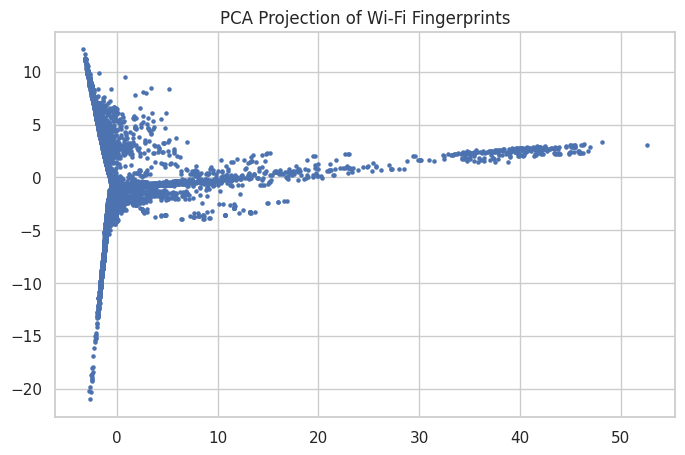

In [16]:
pca = PCA(n_components=2)
proj = pca.fit_transform(X_train_scaled)

plt.scatter(proj[:,0], proj[:,1], s=5)
plt.title("PCA Projection of Wi-Fi Fingerprints")
plt.show()


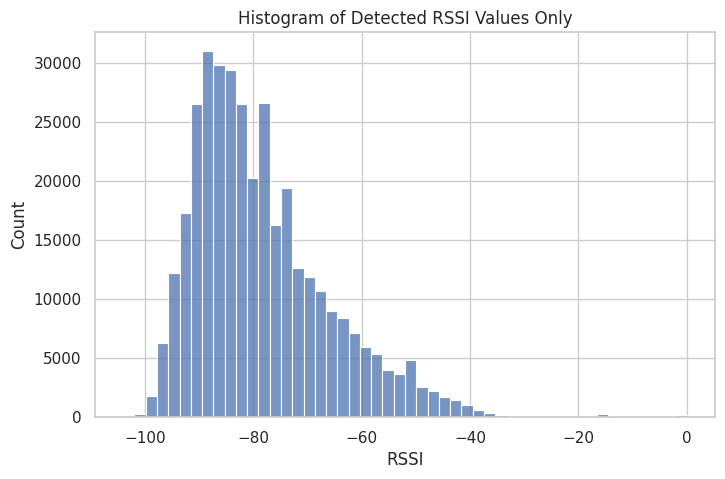

In [18]:
detected = all_rssi[all_rssi > -110]  # remove "no signal"
sns.histplot(detected, bins=50)
plt.title("Histogram of Detected RSSI Values Only")
plt.xlabel("RSSI")
plt.ylabel("Count")
plt.show()


In [17]:
knn = KNeighborsClassifier()

param_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(knn, param_knn, cv=3, n_jobs=-1, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)

grid_knn.best_params_, grid_knn.best_score_


({'n_neighbors': 3, 'weights': 'distance'}, np.float64(0.9828830217861991))

In [19]:
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='macro')

acc_knn, f1_knn


(0.9849548645937813, 0.9840728547023591)

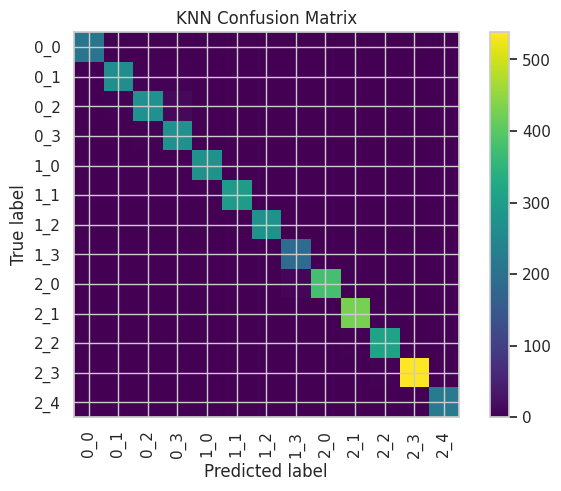

In [20]:
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=best_knn.classes_)

ConfusionMatrixDisplay(cm_knn, display_labels=best_knn.classes_).plot(
    xticks_rotation='vertical', include_values=False
)
plt.title("KNN Confusion Matrix")
plt.show()


In [21]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20]
}

grid_rf = GridSearchCV(rf, param_rf, cv=3, n_jobs=-1, scoring='accuracy')
grid_rf.fit(X_train_raw, y_train)

grid_rf.best_params_, grid_rf.best_score_


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


({'max_depth': None, 'n_estimators': 200}, np.float64(0.9960499090541534))

In [22]:
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_raw)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

acc_rf, f1_rf


(0.9962387161484454, 0.9955471022355057)

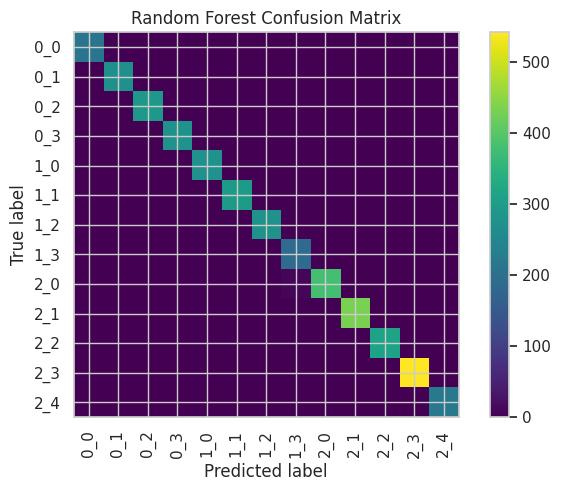

In [23]:
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=best_rf.classes_)

ConfusionMatrixDisplay(cm_rf, display_labels=best_rf.classes_).plot(
    xticks_rotation='vertical', include_values=False
)
plt.title("Random Forest Confusion Matrix")
plt.show()


In [24]:
pd.DataFrame({
    "Model": ["KNN", "Random Forest"],
    "Accuracy": [acc_knn, acc_rf],
    "Macro F1": [f1_knn, f1_rf]
})


,Model,Accuracy,Macro F1
0,KNN,0.984955,0.984073
1,Random Forest,0.996239,0.995547


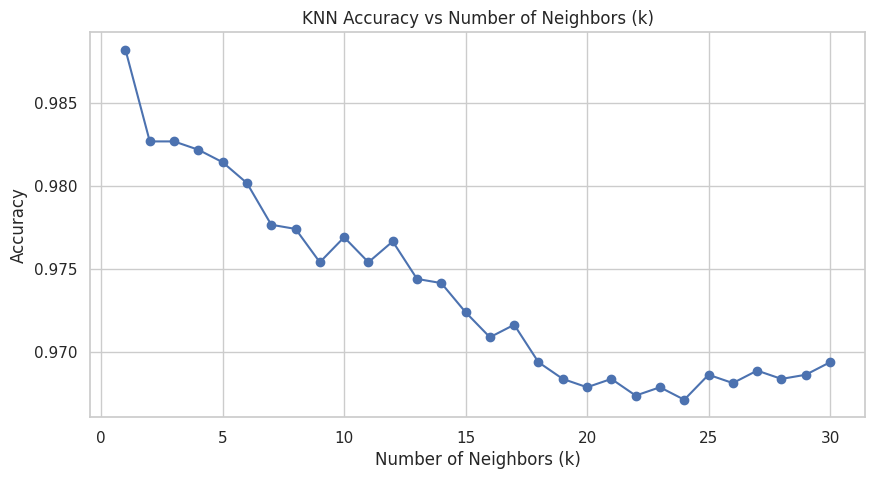

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = range(1, 31)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    preds = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

plt.figure(figsize=(10,5))
plt.plot(k_values, accuracies, marker='o')
plt.title("KNN Accuracy vs Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


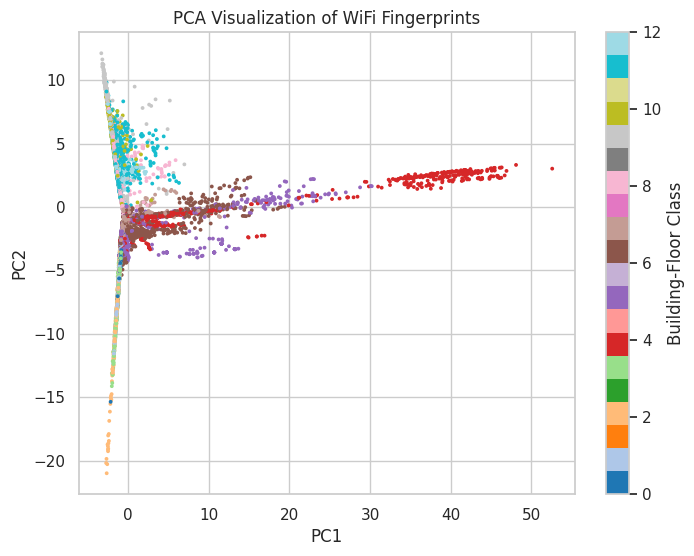

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train.astype('category').cat.codes, cmap='tab20', s=3)
plt.title("PCA Visualization of WiFi Fingerprints")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Building-Floor Class")
plt.show()


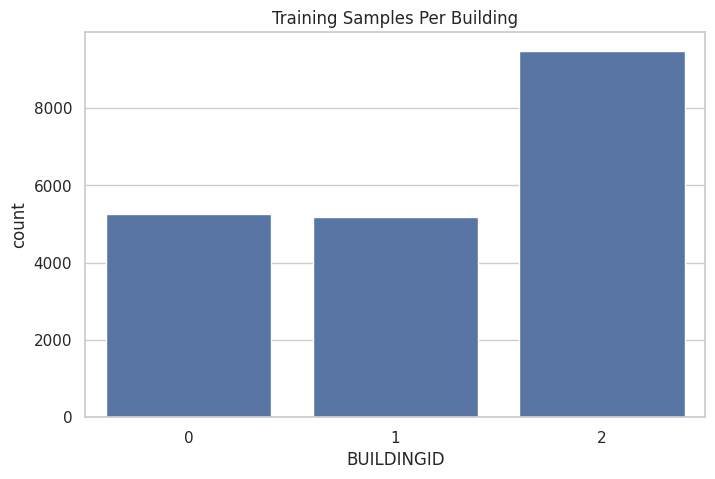

In [27]:
sns.countplot(x=df['BUILDINGID'])
plt.title("Training Samples Per Building")
plt.show()


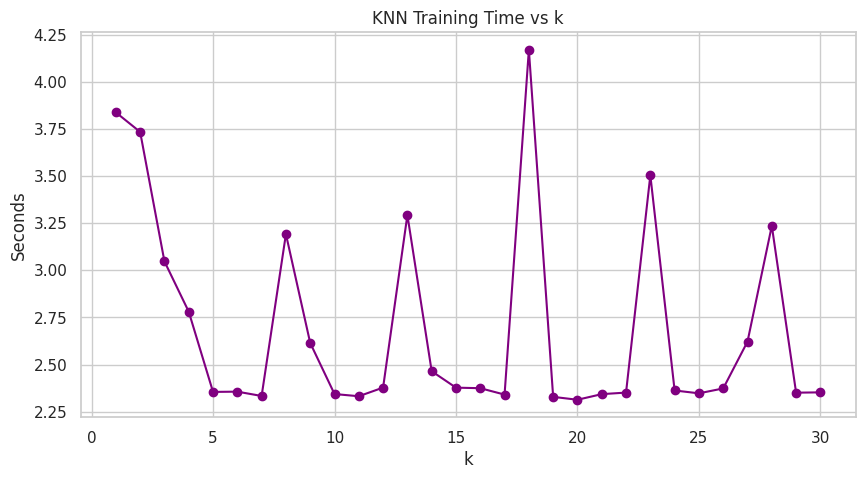

In [28]:
import time

times = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    start = time.time()
    knn.fit(X_train_scaled, y_train)
    preds = knn.predict(X_test_scaled)
    times.append(time.time() - start)

plt.figure(figsize=(10,5))
plt.plot(k_values, times, marker='o', color='purple')
plt.title("KNN Training Time vs k")
plt.xlabel("k")
plt.ylabel("Seconds")
plt.grid(True)
plt.show()
